# SQL Project - An Information System for Monitoring and Improving the Social Well-Being of Elderly People in a Cooperative Neighborhood

## Some prerequisite for running our project 

In [10]:
# Import the necessary libraries

# import sql libraries
import pyodbc

# import data manipulation libraries
import pandas as pd
import datetime as dt
import os
import numpy as np

# import data visualization libraries
import plotly_express as px
import plotly.graph_objs as go
import plotly as py


#import parallel processing libraries
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
import multiprocessing as mp


In [3]:
# Fix the number of CPU used :
nCPU = os.cpu_count()
pool = ThreadPool(processes=nCPU)

In [13]:
PathActivityRating = os.path.abspath(os.path.join(os.path.dirname(__file__),"../Data/activity-rating.csv"))

conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};' + fr'DBQ={PathSQL};')


NameError: name '__file__' is not defined

In [4]:
sql = 'SELECT SA.ActivityName AS Name_of_Activity, S.SessionId AS ID_Session, I.FirstName & " " & I.LastName AS Animators FROM Inhabitant AS I INNER JOIN (SkillActivity AS SA INNER JOIN [Session] AS S ON SA.ActivityName = S.ActivityName) ON I.InHabitantId = S.InHabitantId;'

In [5]:
df = pd.read_sql(sql, conn)

c:\Users\33646\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


DatabaseError: Execution failed on sql 'SELECT SA.ActivityName AS Name_of_Activity, S.SessionId AS ID_Session, I.FirstName & " " & I.LastName AS Animators FROM Inhabitant AS I INNER JOIN (SkillActivity AS SA INNER JOIN [Session] AS S ON SA.ActivityName = S.ActivityName) ON I.InHabitantId = S.InHabitantId;': ('07002', '[07002] [Microsoft][Pilote ODBC Microsoft Access] Trop peu de paramètres. 1 attendu. (-3010) (SQLExecDirectW)')

## SQL Queries :

P2 - R10

In [11]:
QueryP2R10 = 'SELECT V.TextualRemark\
            FROM Visit as V;'

P2R10 = pd.read_sql(QueryP2R10, conn)
P2R10

c:\Users\33646\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,TextualRemark
0,everything is ok
1,everything is ok
2,everything is ok
3,Problem with sugar


In [13]:
#https://stackoverflow.com/questions/33279940/how-to-combine-multiple-rows-of-strings-into-one-using-pandas
P2R10 = P2R10["TextualRemark"].str.cat(sep=' ')

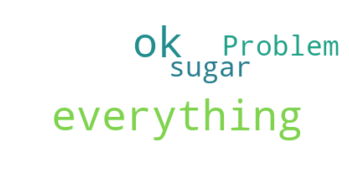

In [19]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

wordcloudP2R10 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(P2R10)

plt.imshow(wordcloudP2R10, interpolation='bilinear')
plt.axis("off")
plt.show()

# 2 - Discovering behavior and detecting worrying changes 

## 1. Calculate of indicators to better understand the log file and represent them with graphics. 

In [39]:
path = "C:/Users/33646/Documents/GitHub/Master-Econometrics-Empirial-Economics/DataBase Project/Data/Solange__Mario.csv"

# Import DataSet with parallelization on the different Cpus to go faster
def import_df(file_name):
    df = pd.read_csv(file_name, encoding = "ISO-8859-1", sep = ";")
    return df
df_SolangeAndMario = pool.apply_async(import_df, (path, )).get() 

In [40]:
#Check the dataset
df_SolangeAndMario

,_CASE_KEY,EVENTTIME,ACTIVITY_EN,Senior,Helper
0,1,15/06/2022 09:00,WakeUp,Solange,Self
1,1,15/06/2022 09:03,Going to toilet,Solange,Self
2,1,15/06/2022 09:10,Taking a shower,Solange,Self
3,1,15/06/2022 09:25,Dressing,Solange,Self
4,1,15/06/2022 09:34,Taking a breakfast,Solange,Self
...,...,...,...,...,...
115,8,18/06/2022 16:01,Phoning,Mario,Self
116,8,18/06/2022 17:01,Collective Dancing,Mario,James
117,8,18/06/2022 19:31,Having Dinner,Mario,Self
118,8,18/06/2022 21:01,Reading,Mario,Self


In [41]:
#check the type of each columns :
print(df_SolangeAndMario.dtypes)

_CASE_KEY       int64
EVENTTIME      object
ACTIVITY_EN    object
Senior         object
Helper         object
dtype: object


In [42]:
# transform the date column into a date format
df_SolangeAndMario['EVENTTIME'] = pd.to_datetime(df_SolangeAndMario['EVENTTIME'])
print(df_SolangeAndMario.dtypes)

_CASE_KEY               int64
EVENTTIME      datetime64[ns]
ACTIVITY_EN            object
Senior                 object
Helper                 object
dtype: object


In [43]:
df_SolangeAndMario

,_CASE_KEY,EVENTTIME,ACTIVITY_EN,Senior,Helper
0,1,2022-06-15 09:00:00,WakeUp,Solange,Self
1,1,2022-06-15 09:03:00,Going to toilet,Solange,Self
2,1,2022-06-15 09:10:00,Taking a shower,Solange,Self
3,1,2022-06-15 09:25:00,Dressing,Solange,Self
4,1,2022-06-15 09:34:00,Taking a breakfast,Solange,Self
...,...,...,...,...,...
115,8,2022-06-18 16:01:00,Phoning,Mario,Self
116,8,2022-06-18 17:01:00,Collective Dancing,Mario,James
117,8,2022-06-18 19:31:00,Having Dinner,Mario,Self
118,8,2022-06-18 21:01:00,Reading,Mario,Self


b) 	Time spent by each activity for each person?

In [59]:
# Calculate time spent in each activity
df_SolangeAndMario['TimeSpent'] = df_SolangeAndMario['EVENTTIME'].diff().shift(-1).fillna(dt.timedelta(0)).apply(lambda x: x.total_seconds()/60)
df_SolangeAndMario

,_CASE_KEY,EVENTTIME,ACTIVITY_EN,Senior,Helper,TimeSpent
0,1,2022-06-15 09:00:00,WakeUp,Solange,Self,3.0
1,1,2022-06-15 09:03:00,Going to toilet,Solange,Self,7.0
2,1,2022-06-15 09:10:00,Taking a shower,Solange,Self,15.0
3,1,2022-06-15 09:25:00,Dressing,Solange,Self,9.0
4,1,2022-06-15 09:34:00,Taking a breakfast,Solange,Self,26.0
...,...,...,...,...,...,...
115,8,2022-06-18 16:01:00,Phoning,Mario,Self,60.0
116,8,2022-06-18 17:01:00,Collective Dancing,Mario,James,150.0
117,8,2022-06-18 19:31:00,Having Dinner,Mario,Self,90.0
118,8,2022-06-18 21:01:00,Reading,Mario,Self,0.0


In [ ]:
# Do an histogram of the time spent in each activity with plotly
px.

# SLEEPING EST NEGATIF FAIRE UN CHECK

In [63]:
#group by activity and sum the time spent by each person
Q1_B = pd.DataFrame(df_SolangeAndMario.groupby(["ACTIVITY_EN","Senior"])["TimeSpent"].sum()).rename(columns={"TimeSpent":"TimeSpentInMinutes"})
Q1_B.reset_index(inplace=True)
Q1_B


,ACTIVITY_EN,Senior,TimeSpentInMinutes
0,Collective Cooking,Mario,150.0
1,Collective Dancing,Mario,300.0
2,Collective Dancing,Solange,600.0
3,Collective Game,Mario,250.0
4,Collective Game,Solange,380.0
5,Collective cooking,Mario,90.0
6,Dressing,Mario,42.0
7,Dressing,Solange,42.0
8,Going to toilet,Mario,28.0
9,Going to toilet,Solange,19.0


c) 	Average time per activity for each senior (Solange and Mario)

In [102]:
#group by activity and do the average the time spent by each person on it
Q1_C = df_SolangeAndMario.groupby(["ACTIVITY_EN","Senior"])["TimeSpent"].mean().reset_index().rename(columns={"TimeSpent":"AVGTimeSpentInMinutes"})
Q1_C

,ACTIVITY_EN,Senior,AVGTimeSpentInMinutes
0,Collective Cooking,Mario,150.000000
1,Collective Dancing,Mario,150.000000
2,Collective Dancing,Solange,150.000000
3,Collective Game,Mario,62.500000
4,Collective Game,Solange,95.000000
5,Collective cooking,Mario,90.000000
6,Dressing,Mario,10.500000
7,Dressing,Solange,10.500000
8,Going to toilet,Mario,7.000000
9,Going to toilet,Solange,4.750000


e-f) https://datatofish.com/compare-values-dataframes/

##      3.	Recommending activities to Solange (Research Question)

In [207]:
# import the data into a pandas dataframe :
# Import DataSet with parallelization on the different Cpus
path = 'C:/Users/33646/Desktop/M2/EEE/DataBase/Project/activity-rating.csv'
def import_df(file_name):
    df = pd.read_csv(file_name, sep=';')
    return df
df_rating = pool.apply_async(import_df, (path, )).get() 

In [208]:
#select the 3 first columns of the dataframe :
df_rating = df_rating.iloc[:,0:3]
df_rating

,UserId,ActivityId,Rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5
...,...,...,...
1229,597,21,5.0
1230,599,21,4.0
1231,602,21,4.0
1232,603,21,5.0


In [209]:
# We count the number of unique users by counting the unique IDs :
nbunique = df_rating['UserId'].nunique()
print(f"There is {nbunique} unique users.")

There is 385 unique users.


        1 ) Calculate the similarity (euclidinian distance)

We do it thanks to this website : https://mlforanalytics.com/2018/04/01/euclidean-distance-for-finding-similarity/

In [245]:
df_rating = pd.pivot_table( data=df_rating, 
                        index= ['UserId'], 
                        columns=['ActivityId'], 
                        values='Rating',
                        aggfunc='mean')
df_rating = df_rating.transpose()
#
dict_rating = df_rating.to_dict()


In [251]:
dict_rating


{'UserId': [1,
  5,
  7,
  15,
  17,
  18,
  19,
  21,
  27,
  31,
  32,
  33,
  40,
  43,
  44,
  45,
  46,
  50,
  54,
  57,
  63,
  64,
  66,
  68,
  71,
  73,
  76,
  78,
  82,
  86,
  89,
  90,
  91,
  93,
  96,
  98,
  103,
  107,
  112,
  119,
  121,
  124,
  130,
  132,
  134,
  135,
  137,
  140,
  141,
  144,
  145,
  151,
  153,
  155,
  156,
  159,
  160,
  161,
  166,
  167,
  169,
  171,
  177,
  178,
  179,
  182,
  185,
  186,
  191,
  193,
  200,
  201,
  202,
  206,
  213,
  214,
  216,
  217,
  219,
  220,
  223,
  226,
  229,
  232,
  233,
  234,
  239,
  240,
  247,
  249,
  252,
  254,
  263,
  264,
  266,
  269,
  270,
  273,
  274,
  275,
  276,
  277,
  279,
  280,
  282,
  283,
  288,
  290,
  291,
  292,
  293,
  298,
  304,
  307,
  314,
  322,
  323,
  328,
  330,
  332,
  334,
  336,
  337,
  339,
  341,
  347,
  350,
  353,
  357,
  359,
  364,
  367,
  372,
  373,
  378,
  380,
  381,
  382,
  385,
  389,
  391,
  396,
  399,
  401,
  411,
  412,
  414,


In [241]:
choices= {'John': {'Mango':4.5, 'Banana':3.5, 'Strawberry':4.0, 'Pineapple':4.0},
'Nick': {'Mango':4.0, 'Orange':4.5, 'Banana':3.0, 'Pineapple':4.5},
'Martha': {'Orange':5.0, 'Banana':2.5, 'Strawberry':4.5, 'Apple':3.5},
'Mathew': {'Mango':3.75, 'Strawberry':4.25, 'Apple':3.5, 'Pineapple':3.0}}


,John,Nick,Martha,Mathew
Mango,4.5,4.0,NaN,3.75
Banana,3.5,3.0,2.5,NaN
Strawberry,4.0,NaN,4.5,4.25
Pineapple,4.0,4.5,NaN,3.00
Orange,NaN,4.5,5.0,NaN
Apple,NaN,NaN,3.5,3.50


In [247]:
from math import sqrt
class testClass():
    
    def choice_distance(self, cho, per1, per2):
        #Will set the following dictionary if data is common for two persons
        sample_data={}
        #Above mentioned varibale is an empty dictionary, that is length =0

        for items in cho[per1]:
            if items in cho[per2]:
                sample_data[items]=1
        #Value is being set 1 for those items which are same for both persons

        #If both person does not have any similarity or similar items return 0
                if len(sample_data)==0: 
                    return 0

        #Calculating Euclidean Distance
        final_sum = sum([pow(cho[per1][items]-cho[per2][items],2) for items in cho[per1] if items in cho[per2]])
        return(1/(1+sqrt(final_sum)))
#Value being returned above always lies between 0 and 1
#Value 1 is added to sqrt to prevent 1/0 division and to normaloze result.

In [248]:
ob = testClass()

In [249]:
print(ob.choice_distance(dict_rating, 66, 69))


KeyError: 69

    2 )  Recommendation algorithm :

We do it thanks to this website :https://mlforanalytics.com/2018/04/04/recommending-items/